# Speech-to-Text Model

### Objective:

Use Convolutional Neural Networks to build a Speech-to-Text Model with Keras and Python. We will use the TensorFlow's Speech Commands Datasets which contains 65,000 one-second long utterances of 30 short words, by thousands of different people. This speech recognition system will understands simple spoken commands.

### Overview:
1. Data exploration and visualisation
2. Preprocessing the data
2. Building the model 
3. Testing the model

## Import libraries
Start by importing the necessary libraries. LibROSA and SciPy are Python libraries used for processing audio signals.

In [1]:
import os
import os.path
from os.path import isdir, join
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
import sounddevice as sd
import keras

Using TensorFlow backend.


## Data Exploration and Visualisation


### Visualisation of Audio signal in time series domain
It's interesting to see what our audio data looks like. Let's represent the audio signal using its amplitude as a function of time. In other words, the features are the amplitudes which are recorded at different time intervals.

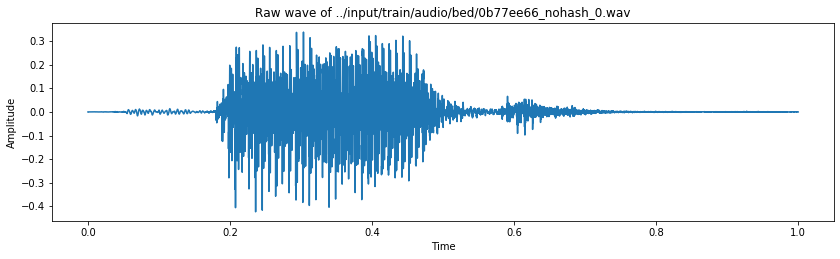

In [2]:
train_audio_path = 'speech_commands_v0.01/audio/'
samples, sample_rate = librosa.load(train_audio_path+'bed/0b77ee66_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/bed/0b77ee66_nohash_0.wav')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

### Sampling rate
We imported our audio data at a sampling rate of 16,000 Hz. This sampling rate produces a very high pitched sound:

In [76]:
ipd.Audio(samples, rate=sample_rate)

In [77]:
print(sample_rate)

16000


### Resampling
As most speech-related frequencies are present at 8000 Hz, let's resample to 8000 Hz. You will notice that the audio now sounds more natural and lifelike:

In [75]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

### Is our dataset balanced?
Looking at the counts of recordings for each voice command, we see that the dataset is fairly balanced. It is okay that our dataset only contains a small number of background noise clips as we are not trying to identify the backround noise itself.

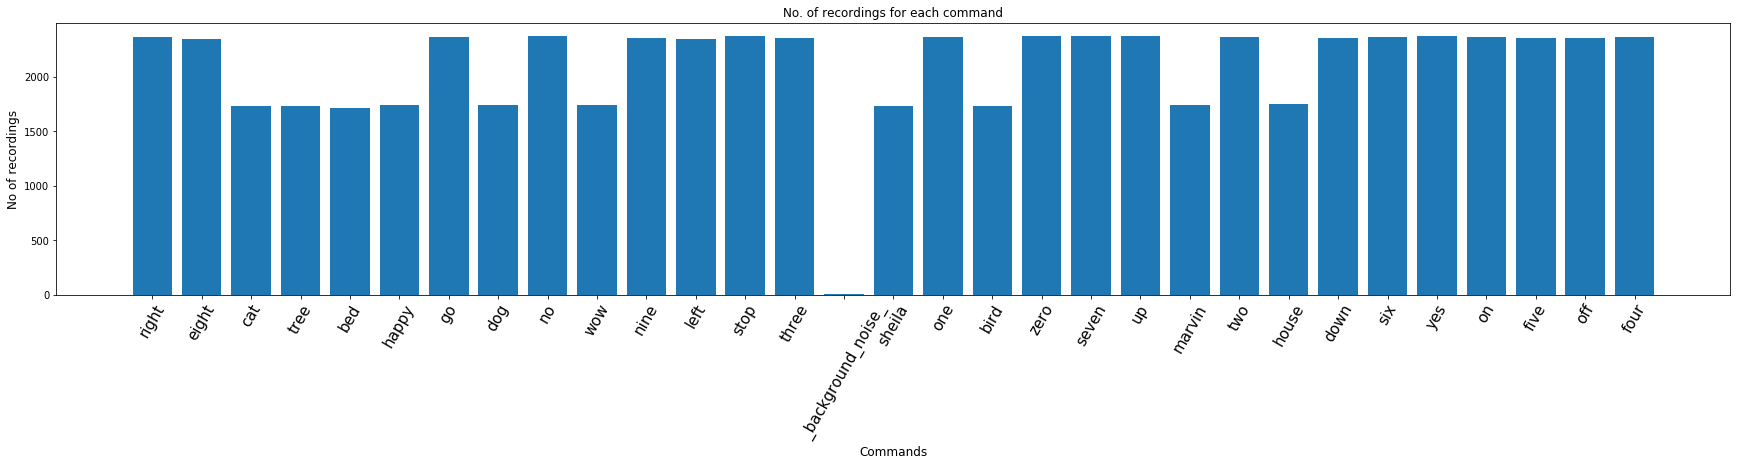

In [3]:
labels = [f for f in os.listdir(train_audio_path) if os.path.isdir(join(train_audio_path, f))]

#Measure count of each label
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot bar chart
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

### Duration of recordings
The description of the dataset mentions that the clips of voice commands last 1 second. We verify this by plotting a bar chart of for the duration of the audio clips and find that we've got some audio clips that are shorter than a second:

Text(0, 0.5, 'File count')

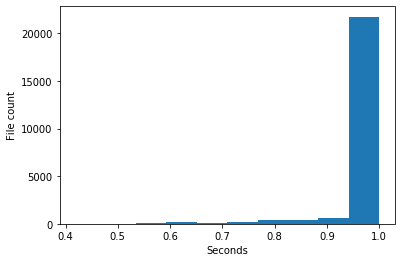

In [16]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))
plt.xlabel('Seconds')
plt.ylabel('File count')

## Data Preprocessing

Now that we've gotten to know our data a little better we can take the appropriate steps to clean and process it in preparation for feeding it to our model.

First, we'll resample all of our audio clips from 16,000 Hz to 8000 Hz. 

Next, we'll remove any audio clips that are shorter than 1 second.

Finally, we collect our audio clips in one list, and their corresponding labels in another list, allowing us to sort our data into predictor and target variables.

We'll execute the above steps in one big loop.

In [4]:
#View the speech command labels we are working with.
train_audio_path = 'speech_commands_v0.01/audio/'
labels = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
labels.sort()
print('Number of labels: ' + str(len(labels[1:])))
print(labels)

Number of labels: 30
['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [5]:
all_wave = []
all_label = []
for label in labels[1:]:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

bed
bird
cat
dog
down
eight
five
four
go
happy
house
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
up
wow
yes
zero


### Encoding the labels
Our labels are categorical so we will first convert them into integer encoded data.

After that, we convert the integer encoded labels into a one-hot vector as we are dealing with a multi-classification problem:

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [7]:
import keras
import keras.utils
from keras import utils as np_utils
#from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

### Reshaping the data
We will need to reshape our data to fit into the layers the model will use. 

Currently our data is a 2-dimensional array. The Conv1D layer we will later use only accepts 3-dimensional input so we reshape our 2D array into a 3D array:

In [13]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

### Splitting the data
We will train the model on 80% of the data and validate it on the remaining 20%:

In [14]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

## Building the model

We will predominantly use 1D CNN in conjuction with 1D Max pooling. 

"A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance."

The pooling layer will help to avoid our model overfitting by reducing the dimension of the input data and thus varying the input data slightly.


We will implement the model using Keras.

In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

We will use categorical cross-entropy for our loss function we are dealing with a multi-classification problem:

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

To ensure that we don't continue training our model once the model performance has stopped improving on the validation set we will deploy early stopping in our callback.

We also add a checkpoint to our callback to save the best model after every epoch:

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [18]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 46601 samples, validate on 11651 samples
Epoch 1/100
46601/46601 [==============================] - 461s 10ms/step - loss: 2.8272 - accuracy: 0.1541 - val_loss: 2.4166 - val_accuracy: 0.2692
Epoch 2/100
46601/46601 [==============================] - 372s 8ms/step - loss: 1.9037 - accuracy: 0.4057 - val_loss: 1.5812 - val_accuracy: 0.5234
Epoch 3/100
46601/46601 [==============================] - 375s 8ms/step - loss: 1.5078 - accuracy: 0.5346 - val_loss: 1.3459 - val_accuracy: 0.6020
Epoch 4/100
46601/46601 [==============================] - 358s 8ms/step - loss: 1.3153 - accuracy: 0.5971 - val_loss: 1.1312 - val_accuracy: 0.6638
Epoch 5/100
46601/46601 [==============================] - 361s 8ms/step - loss: 1.2064 - accuracy: 0.6290 - val_loss: 0.9186 - val_accuracy: 0.7330
Epoch 6/100
46601/46601 [==============================] - 369s 8ms/step - loss: 1.1091 - accuracy: 0.6590 - val_loss: 1.0477 - val_accuracy: 0.6861
Epoch 7/100
46601/46601 [==============================

46601/46601 [==============================] - 408s 9ms/step - loss: 0.5655 - accuracy: 0.8252 - val_loss: 0.6526 - val_accuracy: 0.8048
Epoch 00055: early stopping


## Evaluating the model

Let's understand the performance of the model over time.

We can see that the model reaches a validation accuracy of about 80% and a validation loss of 0.6151. The training and validation losses are in step with each other, as are the training and validation accuracy, suggesting the model is not being underfit or overfit.

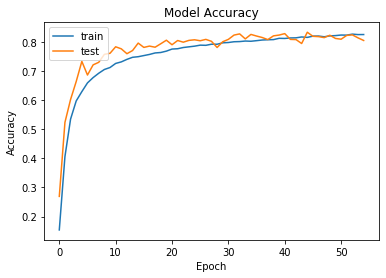

In [23]:
from matplotlib import pyplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

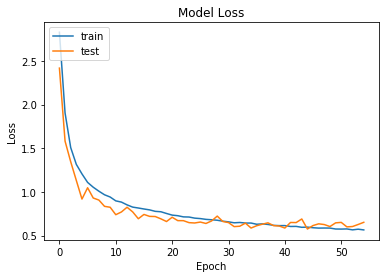

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
#save the model for later use.
model.save('first_speech_to_text_model.hdf5')

## Testing the model

In [20]:
from keras.models import load_model
model=load_model('first_speech_to_text_model.hdf5')

In [65]:
#Defining a function that predicts text for the given audio
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [38]:
#Selecting a random audio clip, feeding it into the model and viewing the outcome
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: yes
Text: yes


## Record and test out your own audio clip on the model!
The code below will allow you record an audio clip directly.

In [35]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # in seconds
filename = 'right.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


Now we read the above saved audio clip and let our model convert it into text:

In [30]:
#directory to your audio clips folder containing clips for testing
os.listdir('speech_commands_v0.01/test_audio/')
filepath='speech_commands_v0.01/test_audio/'

In [69]:
#reading the voice commands
samples_orig, sample_rate = librosa.load(filepath + '/' + 'right.wav', sr = 16000)
samples = librosa.resample(samples_orig[0:16000], sample_rate, 8000)
ipd.Audio(samples,rate=8000) 

#all_wave = np.array(all_wave).reshape(-1,8000,1)

predict(samples)

'right'